In [1]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import time
import multiprocessing as mp
import pandas as pd
import copy
import sys

solver=["BDF","RK23","LSODA","Radau"]

In [2]:
#Class that save the groups of parameters that mutates in each Tournament
class parE:
    def _init_(self):
        self.param = [0]*34

#Class of the average of the subpopulations.
class PopAverage:
    k = 0
    n = 0
    Km = 0
    L = 0
    w = 0
    WCC = 0
    f = 0
    #Function that resets the values of genotype and phenotype
    def reset(self):
        self.k = 0
        self.n = 0
        self.Km = 0
        self.L = 0
        self.w = 0
        self.WCC = 0
        self.f = 0
    #Function that normalize the values of genotype and phenotype by f that contain the time per population size
    def normalize(self,N):
        f = self.f
        self.k /= f
        self.n /= f
        self.Km /= f
        self.L /= f
        self.w /= f
        self.WCC /= f
        self.f /= N
        

In [3]:
#Classs that represent the network of each individual
class GeneNetwork:
    #Genotype parameters
    k = []
    n = []
    KM = []
    L = 0
    kd = []
    x = []
    LD=0
    #Fitness parameters and omega is the convertion parameter of the concentrations to molecules
    v = 0.3
    omega = (14.1371*6.022*10**5)/43
    dawn = 1.5
    dusk = 11
    w = 0
    #Flags and parameters of heredity
    parent = 0
    mut = 0
    LTag = 0
    LMut = 0
    Lm = np.zeros(24)
    LOsc = 0
    LFitm = 0
    LWCC = np.zeros(96)
    LFit = np.zeros(96)
    life=0
    #Propensities
    r = [0]*39
    rT = 0
    #Stequiometric matrix
    V = [[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
         [0,0,-1,-1,1,0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0],
         [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
         [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
         [0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1],
         [0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0],
         [-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0],
         [0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0],
         [0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0],
         [0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0],
         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1]]
    #Time (time, t) and concentrations of the molecules (y)
    time = 0
    y=[]
    t=[0]
    
    #Function of the inicialization of parameters.
    def ic(self,x0,k0,L0,n0,KM0,Kd0,alg):
        self.x = np.array(x0,dtype=float)
        self.k = k0[:]
        self.L = L0
        self.n = n0[:]
        self.KM = KM0[:]
        self.kd = Kd0[:]
        self.y = [[i] for i in self.x]
        if not alg:
            self.omega = 1
            self.sol = solve_ivp(ODE,[0,49],self.x,
                                 args=(self.k,self.L,self.n,self.KM),
                                 dense_output=True)
        self.x *= omega
        self.dawn *= omega
        self.dusk *= omega
        self.LFit = copy.copy(self.LFit)
        self.Lm = copy.copy(self.Lm)
        self.LWCC = copy.copy(self.LWCC)
        
    #Function to update the propensities
    def updateR(self):
        x = self.x
        k = self.k
        L = self.L
        n = self.n
        KM = self.KM
        kd = self.kd
        
        m = self.time%24
        if m>=12 or not self.LD:
            l = 0
        else:
            l = L
        
        self.r[0] = k[0]
        self.r[1] = k[1]*x[5] 
        self.r[2] = k[2]*x[6]
        self.r[3] = k[3]/(1 + KM[0]*x[5])
        self.r[4] = k[4]*x[11]
        self.r[5] = k[5]*x[0] 
        self.r[6] = k[6]*(x[0] + x[10] + KM[1] -  np.sqrt(pow(float(x[0] + x[10] + KM[1]),2) - 4*x[0]*x[10]))/2 
        self.r[7] = k[7]*x[1] 
        self.r[8] = k[8]*x[2]*x[3]
        self.r[9] = k[9]*x[4] 
        self.r[10] = k[10]*x[6] 
        self.r[11] = k[11]*x[5]*(pow(x[11],n[0])/(pow(x[11],n[0]) + pow(KM[2],n[0]))) 
        self.r[12] = k[12]*x[5]
        self.r[13] = k[13]*x[6]*(pow(x[14],n[1])/(pow(x[14],n[1]) + pow(KM[3],n[1]))) 
        self.r[14] = (k[14]*pow(float(KM[5]*x[5]),n[2]))/(pow(float(KM[4]*KM[5]),n[2]) + pow(float(KM[5]*x[5]),n[2]) + pow(float(KM[4]*x[6]),n[2])) 
        self.r[15] = (k[15]*pow(float(KM[4]*x[6]),n[2]))/(pow(float(KM[4]*KM[5]),n[2]) + pow(float(KM[5]*x[5]),n[2]) + pow(float(KM[4]*x[6]),n[2])) 
        self.r[16] = k[16]*x[7]
        self.r[17] = k[17]*x[8] 
        self.r[18] = k[18]*x[9] 
        self.r[19] = k[19]*x[10] 
        self.r[20] = k[20]*(pow(x[6],n[3])/(pow(KM[6],n[3]) + pow(x[6],n[3]))) 
        self.r[21] = k[21]*x[12]
        self.r[22] = k[22]*x[13]
        self.r[23] = l*x[5] 
        self.r[24] = kd[0]*x[0] 
        self.r[25] = kd[1]*x[1] 
        self.r[26] = kd[2]*x[2] 
        self.r[27] = kd[3]*x[3] 
        self.r[28] = kd[4]*x[4] 
        self.r[29] = kd[5]*x[5]
        self.r[30] = kd[6]*x[6] 
        self.r[31] = kd[7]*x[7] 
        self.r[32] = kd[8]*x[8]
        self.r[33] = kd[9]*x[9] 
        self.r[34] = kd[10]*x[10] 
        self.r[35] = kd[11]*x[11] 
        self.r[36] = kd[12]*x[12] 
        self.r[37] = kd[13]*x[13] 
        self.r[38] = kd[14]*x[14]
        
        self.rT = sum(self.r)
    
    #Function to calculate the time of stochastic models
    def updateTime(self):
        rand1 = np.random.rand()
        
        self.updateR()
        re_time = -np.log(1-rand1)/self.rT
        self.time += re_time
        if int(self.time*2)>int((self.time - re_time)*2):
            self.t.append((self.time//.5)*.5)
    
    #Function to select the reactions of the stochastic models
    def updateSystem(self):
        r = self.r
        rT = self.rT
        rand2 = np.random.rand()
        rR = sum(rand2>(np.cumsum(r)/rT))
        self.x += self.V[rR]
        if len(self.t)>len(self.y[0]):
            self.y = np.append(self.y,self.x.reshape(15,1),axis=1)
    
    #Calculation of the fitness by lorentzian function
    def calculateFit(self):
        def Opt(time):
            return yd + amp*(np.cos(2*np.pi*(time+12)/24))
        WCC = self.x[5]
        time = self.time
        v = self.v
        amp = (self.dusk-self.dawn)/2
        yd = self.dawn + amp
        #WCCopt = np.array([Opt(time-2),Opt(time+2),Opt(time)-0.5,Opt(time)+0.5])
        #if WCC>min(WCCopt) and WCC<max(WCCopt):
        #    self.w=1
        #else:
        #    dif=min(abs(WCCopt-WCC))
        #    self.w =  1/(1+((dif)**2/(v*WCCopt[dif==abs(WCCopt-WCC)][0])))
        WCCopt=Opt(time)
        self.w =  1/(1+((WCC-WCCopt)**2/(v*WCCopt)))
    
    #Function of mutations
    def mutate(self,M,par_E):
        global k0, Km0
        
        randl = np.random.rand(35)
        qm = pow(M,(1-(2*randl)))
        qm *= par_E.param
        qm = np.where(qm>0,qm,1)
        
        self.k *= qm[0:23]
        self.n *= qm[23:27]
        self.KM *= qm[27:34]
        self.L *= qm[34]
        
        self.n[self.n>20] = 20
        self.k = np.where(self.k>(np.array(k0)*100),(np.array(k0)*100),self.k)
        self.KM = np.where(self.KM>(np.array(Km0)*100),(np.array(Km0)*100),self.KM)
        
        self.mut = 1
        self.LMut += 1

In [4]:
def ODE(tm,y,k0,L0,n0,K0):
    
    k=k0
    L=L0
    n=n0
    K=K0
    kd=[2.4,2.5,0.135,0.085,0.05,0.05,6,2,0.27,0.27,0.27,0.27,6.2,0.24,0.24]
    
    #Tiempo y periodos LD
    m=Decimal(tm)%Decimal(24)
    if float(m)>=12:
        l = 0
    else:
        l = L

    #Ecuaciones 
    v0 = k[0]
    v1 = k[1]*y[5]
    v2 = k[2]*y[6]
    v3 = k[3]/(1 + K[0]*y[5])
    v4 = k[4]*y[11]
    v5 = k[5]*y[0]
    v6 = k[6]*(y[0] + y[10] + K[1] -  np.sqrt(pow(float(y[0] + y[10] + K[1]),2) - 4*y[0]*y[10]))/2
    v7 = k[7]*y[1]
    v8 = k[8]*y[2]*y[3]
    v9 = k[9]*y[4]
    v10 = k[10]*y[6]
    v11 = k[11]*y[5]*(pow(y[11],n[0])/(pow(y[11],n[0]) + pow(K[2],n[0])))
    v12 = k[12]*y[5]
    v13 = k[13]*y[6]*float(pow(y[14],n[1])/float(pow(y[14],n[1]) + pow(K[3],n[1])))
    v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
    v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
    v16 = k[16]*y[7]
    v17 = k[17]*y[8]
    v18 = k[18]*y[9]
    v19 = k[19]*y[10]
    v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))
    v21 = k[21]*y[12]
    v22 = k[22]*y[13]
    v23 = l*y[5]
    v24 = kd[0]*y[0]
    v25 = kd[1]*y[1]
    v26 = kd[2]*y[2]
    v27 = kd[3]*y[3]
    v28 = kd[4]*y[4] 
    v29 = kd[5]*y[5]
    v30 = kd[6]*y[6] 
    v31 = kd[7]*y[7] 
    v32 = kd[8]*y[8]
    v33 = kd[9]*y[9] 
    v34 = kd[10]*y[10] 
    v35 = kd[11]*y[11] 
    v36 = kd[12]*y[12] 
    v37 = kd[13]*y[13] 
    v38 = kd[14]*y[14]
    
    
    dwc1 = v0 + v1 + v2 - v24
    dwc2 = v3 + v4 - v25
    dWC1 = v5 + v6 - v8 - v26
    dWC2 = v7 - v27 - v8
    dWCCc = v8 - v28 -  v9
    dWCCn = v9 + v10 - v29 - v23 - v12 - v11
    dlaWCC = v23 + v12 - v30 - v10 - v13
    dfrq =  v14 + v15 - v31
    dFRQ =  v16 - v32 - v17
    dFFC = v17 - v33 - v18
    dFFCp = v18 - v34 - v19
    dFFCn = v19 - v35
    dvvd = v20 - v36
    dVVDc = v21 - v37 -  v22
    dVVDn = v22 - v38
    return [dwc1, dwc2, dWC1, dWC2, dWCCc, dWCCn, dlaWCC, dfrq, dFRQ, dFFC, dFFCp, dFFCn, dvvd, dVVDc, dVVDn]

#Function of the Tournament
def selectionTournament(myPop, N, st, u, M, par_E):
    global alg
    global Winers
    #Matrix with the groups of parameters that mutates togheter.
    mutscenarios = [[1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                    [0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
                    [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0],
                    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,1]]
    
    #Selection of the gruop of individuals that compete.
    indexT = np.random.randint(N,size=st)
    indexT = pd.unique(indexT)
    while len(indexT)<st:
        indexT = np.append(indexT,np.random.randint(N,size=(st-len(indexT))))
        indexT = pd.unique(indexT)
    #Selection of the best fitness individual.
    maxT = indexT[-1]
    mw=[myPop[indexT[-1]].w]
    for i in range(len(indexT)-1):
        mw.append(myPop[indexT[i]].w)
        if myPop[indexT[i]].w>myPop[maxT].w:
            maxT=indexT[i]
    mw=pd.DataFrame(mw,columns=["Fitness"])
    #Birth and death
    j = np.random.randint(N)
    a=pd.Series([maxT,myPop[maxT].w,j,myPop[j].w],index=["imax","Fitmax","death","Fitdeath"])
    Winers.append(pd.concat([mw["Fitness"].describe(),a]))
    myPop[j] = copy.deepcopy(myPop[maxT])
    myPop[j].parent = maxT
    myPop[j].life=0
    
    #Choose if the new individual have a mutation
    if np.random.rand() <= u:
        #Choose the kind of mutation
        par_E.param = mutscenarios[np.random.randint(8)]
        #Mutate and recalculate the solution of deterministics models
        myPop[j].mutate(M,par_E)
        if not alg:
            try:
                myPop[j].sol = solve_ivp(ODE,[myPop[j].time,(tGen//24+1)*48+1],myPop[j].x,
                                     args=(myPop[j].k,myPop[j].L,myPop[j].n,myPop[j].KM),
                                     method=solver[0],dense_output=True)
            except:
                myPop[j].sol = solve_ivp(ODE,[myPop[j].time,(tGen//24+1)*48+1],myPop[j].x,
                                     args=(myPop[j].k,myPop[j].L,myPop[j].n,myPop[j].KM),
                                     method=solver[1],dense_output=True)
            finally:
                if not myPop[j].sol.success:
                    myPop[j].sol = solve_ivp(ODE,[myPop[j].time,(tGen//24+1)*48+1],myPop[j].x,
                                         args=(myPop[j].k,myPop[j].L,myPop[j].n,myPop[j].KM),
                                         method=solver[2],dense_output=True)
                

In [5]:
#Function of each individual simulation at the next event of birth and death
def Simulations(Ind):
    #Global variables that are need
    global myPop
    global myPopT
    global alg
    global iG
    global tWait
    global tGlobal
    global tGen
    global tCycle
    global resultI
    global resultLxC
    global Cp
    global tCC
    #Stochastic simulations
    if alg:
        while myPop[Ind].time < iG:
            myPop[Ind].updateTime()
            myPop[Ind].updateSystem()
    #Deterministic simulation
    else:
        myPop[Ind].time = iG
        myPop[Ind].x = myPop[Ind].sol.sol(iG).round(4)
        if ((iG-tWait)//0.5)*0.5<tGlobal:
            myPop[Ind].t = np.append(myPop[Ind].t,myPop[Ind].time.round(2))
            myPop[Ind].y = np.append(myPop[Ind].y,myPop[Ind].x.reshape(15,1),axis=1)
    myPop[Ind].life+=tWait
    #Calculate the fitness of each individual
    #if (tCC>11 and tCC<14) or (tCC>22 or tCC<2):
    myPop[Ind].calculateFit()
        #Calculate the Fitness lineage
    myPop[Ind].LFitm += (myPop[Ind].w*tWait)
    #else:
     #   myPop[Ind].w=0
    myPop[Ind].LFit[int(tGlobal/0.5)%96] = myPop[Ind].w
    #Average parameters
    myPopT.k += np.array(np.array(myPop[Ind].k)*tWait, dtype = float)
    myPopT.Km += np.array(np.array(myPop[Ind].KM)*tWait, dtype = float)
    myPopT.L += myPop[Ind].L*tWait
    myPopT.n += np.array(np.array(myPop[Ind].n)*tWait, dtype = float)
    myPopT.w += myPop[Ind].w*tWait
    myPopT.WCC += myPop[Ind].x[5]*tWait
    myPopT.f += tWait
    
    
    #Each generation certain information are saved to the individual information and lineage per cycle
    if int(iG/TMAX)>tGen:
        #Its saved the individual information of 100 individuals
        if Ind in range(0,N,10):
            resultI.append(copy.deepcopy([tGen+1,Ind,myPop[Ind].k,myPop[Ind].L,myPop[Ind].KM,myPop[Ind].n,
                            #myPop[i].period,myPop[i].amp,myPop[i].tau,
                            myPop[Ind].w,myPop[Ind].y[5],myPop[Ind].t,myPop[Ind].parent,myPop[Ind].mut]))
        myPop[Ind].LWCC[int(tGen%24)*4:int((tGen%24+1)*4)]=myPop[Ind].y[5][1:]
        
        #Slope sign at each generation
        dif=myPop[Ind].y[5][0]-myPop[Ind].y[5][-1]
        if dif:
            myPop[Ind].Lm[int(tGen%24)]=dif/abs(dif)
        else:
            myPop[Ind].Lm[int(tGen%24)]=0
        #Re-start the concentration and time of the individuals at each generation
        myPop[Ind].y = [[i] for i in myPop[Ind].x]
        myPop[Ind].t = [myPop[Ind].time]
        myPop[Ind].mut = 0
        #Lineage per cycle information
        if ((tGen+1)%Cp)==0:
            #Kind of oscilation of the lineage
            if (Osc==myPop[Ind].Lm).all():
                myPop[Ind].LOsc=0
            elif sum(myPop[Ind].Lm)==0:
                myPop[Ind].LOsc=1
            else:
                myPop[Ind].LOsc=2
                
            
            #Save Lineage per cycle information
            resultLxC.append(copy.deepcopy([tGen+1,myPop[Ind].LTag,myPop[Ind].LMut,
                              myPop[Ind].LFitm/tCycle,myPop[Ind].LFit,myPop[Ind].LWCC,
                              myPop[Ind].LOsc,myPop[Ind].Lm,myPop[Ind].k,
                              myPop[Ind].L,myPop[Ind].KM,myPop[Ind].n]))
            #Re-start the flags of the lineage and new solver to the next cycle.
            myPop[Ind].LFitm = 0
            myPop[Ind].LMut = 0
            myPop[Ind].LTag = Ind
            if not alg:
                try:
                    myPop[Ind].sol = solve_ivp(ODE,[myPop[Ind].time,((tGen+1)//24+1)*48+1],myPop[Ind].x,
                                         args=(myPop[Ind].k,myPop[Ind].L,myPop[Ind].n,myPop[Ind].KM),
                                         method=solver[0],dense_output=True)
                except:
                    myPop[Ind].sol = solve_ivp(ODE,[myPop[Ind].time,((tGen+1)//24+1)*48+1],myPop[Ind].x,
                                         args=(myPop[Ind].k,myPop[Ind].L,myPop[Ind].n,myPop[Ind].KM),
                                         method=solver[1],dense_output=True)
                finally:
                    if not myPop[Ind].sol.success:
                        myPop[Ind].sol = solve_ivp(ODE,[myPop[Ind].time,((tGen+1)//24+1)*48+1],myPop[Ind].x,
                                             args=(myPop[Ind].k,myPop[Ind].L,myPop[Ind].n,myPop[Ind].KM),
                                             method=solver[2],dense_output=True)

In [6]:
#ParameteresultIhe simulation
N = 1000 #Number of the population
st = 500 #Selection parameter
u = 0.03 #mutation rate
M = 1.1 #mutation factor
g = 1 #Number of initial genotypes
alg = 0 #type of simulation(Deterministic=0 and stochastic=1)
LD = 0 #type of environment(LD=0, DD=1)
#Omega selection to the initial conditions
if alg:
    omega = (14.1371*6.022*10**5)/43
else:
    omega = 1

TMAX = 2 #Time of generations
rRE = [0.3,0.4,0.5,0.6] #Rates of reproduction
GMAX = 480  #Number of generations
Cp = 24 #Number of generations that complete a cycle
period = 24  #Period of optimal oscilation
#Initial parameters
x0 = [0.5356, 0.6377, 0.0224, 13.3137, 0.4153, 0.1235, 0, 0.0035, 0.0282, 0.0019, 0.0137, 0.0066, 0, 0, 0]
k0 = [9.18236260e-01*omega, 1.31272389e+00, 1.05612953e+02, 1.51368699e+00*omega, 3.34960765e-02, 2.23445399e-01, 
      2.12373377e+00, 2e+00, 4.72000000e-01/omega, 3.00000000e-01, 1.00000000e-03, 8.22563158e+00, 1.0e-03, 
      1.08551588e+01, 3.49620056e+00, 3.43058956e+02*omega, 5.40000000e+00, 1.50e-01, 2e+00, 5e-02, 8.58342556e+02*omega, 
      6.80000000e-01, 3.00000000e-01]
#k0 = [1.19*omega,1.2,90,1.6*omega,0.03,0.226,0.8,1,0.472/omega,0.3,0.001,0.6,0.001,20,7.3,320*omega,0.19,
#      0.15,0.1,0.1,800*omega,0.68,0.3]
L0 = 0.2
n0 = [4, 4, 4, 4]
Km0 = [0.0271708/omega,  0.29283663*omega, 0.04372374*omega, 4.63129806*omega, 3.89618486*omega, 0.1634689*omega, 0.01747003]
#Km0 = [0.03/omega,1*omega,0.475*omega,5*omega,0.1*omega,0.18*omega,0.02*omega]
kd0 = [2.4, 2.5, 0.135, 0.085, 0.05, 0.05, 6, 1, 0.69, 0.34, 0.34, 0.1, 6.2, 0.24, 0.24]
#Values of the slope of the perfect oscilation
Osc=np.append(np.ones(6),np.ones(6)*-1)
Osc=np.append(Osc,Osc)
Winers=[]

par_E = parE()
numrep = 3
#Computational Time that iniciates the simulation
inicio = time.time()
print("Initial conditions: u{}_M{}_g{}_st{}_N{}_v0.3_alg{}_{}".format(u,M,g,st,N,alg,numrep-1))
sys.stdout.flush()
#Réplicas
for iS in range(numrep-1,numrep):
    #Inizializates the population
    myPop = [GeneNetwork() for i in range(0,N)]
    myPopT = PopAverage()
    #Variables that save the results
    resultAGS = []
    resultLxC = []
    resultI = []
    #Different times
    tGen = 0 #Number of generations
    tCycle = 0 #Number of time for each cycle
    tGlobal = 0 #Time to save concentrations
    iG = 0 #Time of the simulation
    
    #Inizializates the population with the initial parameters
    randl = np.random.rand(g+1,35)
    for i in range(0,N):
        qm = pow(2,(1-(2*randl[i%g])))
        
        k1 = k0*qm[0:23]
        n1 = n0*qm[23:27]
        Km1 = Km0*qm[27:34]
        L1 = L0*qm[34]
        
        myPop[i].ic(x0,k1,L1,n1,Km1,kd0,alg)
        myPop[i].LTag = i
        myPop[i].LD = LD
        myPop[i].period = period
    #Generaciones
    while iG < TMAX*GMAX:
        #linajes
        #Calculate the percentage of reproduction
        iR = int((iG%24)//6)
        rLE = int((N*rRE[iR])/TMAX)
        #Calculate the time of the events
        tWait = -np.log(1 - np.random.rand())/rLE
        #Update the times
        iG += tWait
        tGlobal = (iG//0.5)*0.5
        tCC = iG%24
        
        #Time of the cycle to the normalization
        #if (tCC>11 and tCC<14) or (tCC>22 or tCC<2):
        tCycle += tWait
        
        #Run the simulations
        for i in range(0,N):
            Simulations(i)
        
        #For each generation its saved the average information
        if int(iG/TMAX)> tGen:
            #Update the generation time and normalize the population info
            tGen=iG//TMAX
            myPopT.normalize(N)
            resultAGS.append(copy.deepcopy([tGen,myPopT.k,myPopT.L,myPopT.Km,myPopT.n,
                              #myPopT.period,myPopT.amp,myPopT.tau,
                              myPopT.WCC,myPopT.w]))
            #Reset the Average info
            myPopT.reset()
            #Saves temporarily each cycle
            if tGen%Cp==0:
                tmpI = pd.DataFrame(resultI,columns=["Generation","Cell tag",
                                            "Expresion and repression","Constant of light rate",
                                            "Disociation Constants", "Hill exponents",
                                            #"Period","Amplitude","Tau",
                                            "Fitness","WCCn","Time","Parent tag","Mutation"])
    
                tmpLxC = pd.DataFrame(resultLxC,columns=["Generation","LTag","LMut","LFit",
                                                         "Fitness","WCC","LOsc","Lm",
                                                        "Expresion and repression","Constant of light rate",
                                                        "Disociation Constants", "Hill exponents"])
    
                tmpAGS = pd.DataFrame(resultAGS,columns=["Generation", "Expresion and repression constants",
                                                         "Constant of light rate","Disociation constants", 
                                                         "Hill exponents", #"Period","Amplitude","Tau",
                                                         "WCC","Fitness"])
    
                tmpI.to_csv("Result/Ind_inf_u{}_M{}_g{}_st{}_N{}_v{}_alg{}_{}.csv".format(u,M,g,st,N,myPop[0].v,alg,iS))
                tmpLxC.to_csv("Result/LineagexCycle_u{}_M{}_g{}_st{}_N{}_v{}_alg{}_{}.csv".format(u,M,g,st,N,myPop[0].v,alg,iS))
                tmpAGS.to_csv("Result/AveGenSub_u{}_M{}_g{}_st{}_N{}_v{}_alg{}_{}.csv".format(u,M,g,st,N,myPop[0].v,alg,iS))
                #Print that I utilize to know the time of the simulation
                print(tGen,"/",GMAX," generations")
                #Reset the cycle time
                tCycle=0
                sys.stdout.flush()
        #Tournament selection each event
        selectionTournament(myPop, N, st, u, M, par_E)
        
    #Saves when a replicate finish
    resultI = pd.DataFrame(resultI,columns=["Generation","Cell tag",
                                            "Expresion and repression","Constant of light rate",
                                            "Disociation Constants", "Hill exponents",
                                            #"Period","Amplitude","Tau",
                                            "Fitness","WCCn","Time","Parent tag","Mutation"])
    
    resultLxC = pd.DataFrame(resultLxC,columns=["Generation","LTag","LMut","LFit",
                                                "Fitness","WCC","LOsc","Lm",
                                                "Expresion and repression","Constant of light rate",
                                                "Disociation Constants", "Hill exponents"])
    
    resultAGS = pd.DataFrame(resultAGS,columns=["Generation","Expresion and repression constants",
                                                "Constant of light rate","Disociation constants", 
                                                "Hill exponents",#"Period","Amplitude","Tau",
                                                "WCC","Fitness"])
    
    resultrep=pd.concat(Winers,axis=1)
    resultrep.to_csv("Result/Reproduction_u{}_M{}_g{}_st{}_N{}_v{}_alg{}_{}.csv".format(u,M,g,st,N,myPop[0].v,alg,iS))
    resultI.to_csv("Result/Ind_inf_u{}_M{}_g{}_st{}_N{}_v{}_alg{}_{}.csv".format(u,M,g,st,N,myPop[0].v,alg,iS))
    resultLxC.to_csv("Result/LineagexCycle_u{}_M{}_g{}_st{}_N{}_v{}_alg{}_{}.csv".format(u,M,g,st,N,myPop[0].v,alg,iS))
    resultAGS.to_csv("Result/AveGenSub_u{}_M{}_g{}_st{}_N{}_v{}_alg{}_{}.csv".format(u,M,g,st,N,myPop[0].v,alg,iS))

#Print the time that are needed to complete the evolutionary simulation
fin = time.time()
print("Run Time: ",fin-inicio)

Initial conditions: u0.03_M1.1_g1_st500_N1000_v0.3_alg0_2


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:30: RuntimeWarning: invalid value encountered in double_scalars
  v13 = k[13]*y[6]*float(pow(y[14],n[1])/float(pow(y[14],n[1]) + pow(K[3],n[1])))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeW

24.0 / 480  generations


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))


48.0 / 480  generations


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local

72.0 / 480  generations
96.0 / 480  generations
120.0 / 480  generations


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))


144.0 / 480  generations


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local

168.0 / 480  generations


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local

192.0 / 480  generations


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local

216.0 / 480  generations


C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v14 = (k[14]*pow(float(K[5]*y[5]),n[2]))/(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:32: RuntimeWarning: invalid value encountered in double_scalars
  v15 = (k[15]*pow(float(K[4]*y[6]),n[2]))/float(pow(float(K[4]*K[5]),n[2]) + pow(float(K[5]*y[5]),n[2]) + pow(float(K[4]*y[6]),n[2]))
C:\Users\emman\AppData\Local\Temp\ipykernel_24824\1720375541.py:37: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*(pow(y[6],n[3])/(pow(K[6],n[3]) + pow(y[6],n[3])))


240.0 / 480  generations
264.0 / 480  generations
288.0 / 480  generations
312.0 / 480  generations
336.0 / 480  generations
360.0 / 480  generations
384.0 / 480  generations
408.0 / 480  generations
432.0 / 480  generations
456.0 / 480  generations
480.0 / 480  generations
Run Time:  15020.052859067917


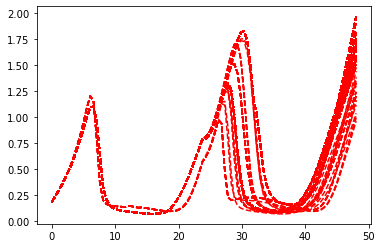

In [7]:
LW=[[0]*96]
for i in range(1000):
    LW=np.append(LW,np.array(np.mat(tmpLxC["WCC"][i])),axis=0)
LW=LW[1:]
plt.plot(np.linspace(0,48,96),LW[tmpLxC["LMut"][:1000]==0].T,"-b")
plt.plot(np.linspace(0,48,96),LW[tmpLxC["LMut"][:1000]!=0].T,"--r")
plt.show()

In [8]:
a=pd.concat(Winers,axis=1)
a.T

,count,mean,std,min,25%,50%,75%,max,imax,Fitmax,death,Fitdeath
0,500.0,0.191963,1.528086e-15,0.191963,0.191963,0.191963,0.191963,0.191963,500.0,0.191963,282.0,0.191963
1,500.0,0.192008,8.057178e-16,0.192008,0.192008,0.192008,0.192008,0.192008,172.0,0.192008,769.0,0.192008
2,500.0,0.192120,2.111536e-15,0.192120,0.192120,0.192120,0.192120,0.192120,705.0,0.192120,534.0,0.192120
3,500.0,0.192298,1.611436e-15,0.192298,0.192298,0.192298,0.192298,0.192298,611.0,0.192298,233.0,0.192298
4,500.0,0.192342,1.194685e-15,0.192342,0.192342,0.192342,0.192342,0.192342,933.0,0.192342,718.0,0.192342
...,...,...,...,...,...,...,...,...,...,...,...,...
216780,500.0,0.472759,4.063154e-01,0.004213,0.047863,0.361865,0.972722,0.997503,918.0,0.997503,742.0,0.727719
216781,500.0,0.469391,4.086018e-01,0.004214,0.041519,0.361860,0.972719,0.997504,464.0,0.997504,298.0,0.997504
216782,500.0,0.467385,4.126685e-01,0.004214,0.041519,0.356152,0.972712,0.997506,67.0,0.997506,641.0,0.065476
216783,500.0,0.476993,4.093997e-01,0.004214,0.041653,0.361876,0.972740,0.997482,802.0,0.997482,141.0,0.105058


In [9]:
print((a.loc["Fitmax"]==a.loc["max"]).describe(),"\n",
      (a.loc["Fitmax"]>a.loc["Fitdeath"]).describe(),"\n",
      a.loc["imax"].describe(),"\n",
      a.loc["death"].describe())

count     216785
unique         1
top         True
freq      216785
dtype: object 
 count     216785
unique         2
top         True
freq      206867
dtype: object 
 count    216785.000000
mean        501.003151
std         288.280363
min           0.000000
25%         251.000000
50%         503.000000
75%         751.000000
max         999.000000
Name: imax, dtype: float64 
 count    216785.000000
mean        499.637982
std         288.455694
min           0.000000
25%         250.000000
50%         500.000000
75%         750.000000
max         999.000000
Name: death, dtype: float64
